In [1]:
!git clone https://github.com/Kenny3Shen/pytorch-metric-learning.git
!pip install /kaggle/working/pytorch-metric-learning

Cloning into 'pytorch-metric-learning'...
remote: Enumerating objects: 9855, done.
remote: Counting objects: 100% (9855/9855), done.
remote: Compressing objects: 100% (2720/2720), done.
remote: Total 9855 (delta 6926), reused 9629 (delta 6829), pack-reused 0
Receiving objects: 100% (9855/9855), 37.88 MiB | 17.35 MiB/s, done.
Resolving deltas: 100% (6926/6926), done.
Processing ./pytorch-metric-learning
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-metric-learning: filename=pytorch_metric_learning-2.5.0-py3-none-any.whl size=119167 sha256=f83244b71b1ee0f344de34a8057d9b9ee5b6e7adfea3b643383b75ab9f12d6c9
  Stored in directory: /root/.cache/pip/wheels/db/12/24/e0cf2e011070fdf08f09005aca1c43bcafe26549104e2e5d5a
Successfully built pytorch-metric-learning


In [2]:
# import os
# import shutil

# src_dir = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled"
# dst_dir = "/kaggle/working/lfw"

# os.makedirs(dst_dir, exist_ok=True)

# for folder_name in os.listdir(src_dir):
#     folder_path = os.path.join(src_dir, folder_name)
#     if os.path.isdir(folder_path) and len(os.listdir(folder_path)) >= 30:
#         shutil.copytree(folder_path, os.path.join(dst_dir, folder_name))

In [3]:
from fastai.vision.all import *
from pytorch_metric_learning import distances, losses, miners, reducers, testers, regularizers, samplers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from torchvision import datasets, transforms
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
DP = True if torch.cuda.device_count() > 1 else False
# set_seed 42
no_random(seed=42,reproducible=True)

valid_pct = 0.2  # 验证集比例

use_attention = None # None, 'se', 'cbam', 'triplet'
attention_kernel_size = 7 # 3, 7, 13
with_embed = False   # 是否使用度量学习，否则只用交叉熵损失
with_local = False  # 是否使用局部特征
if with_local:
    with_horizontal = True  # 是否使用水平切块
    with_vertical = True    # 是否使用垂直切块
global_pooling = 'GeM'    # None, 'GeM', 'GAP', 'GMP'
if global_pooling=='GeM': 
    GeM_p = 4    # GeM pooling 的 p 值

add_ap_dist = None # None, 'max', 'mean', 'min'
if add_ap_dist:    # 使用 ap_dist 时，需要修改源代码
    alpha = 0.7    # add_ap_dist 的权重系数

re_sample=False   #训练集 batch 内是否重新采样
if re_sample:
    m=8

size=256 if with_local else 224  # 图片尺寸 224->7  256->8
chunk_nums = 4 # 对最后一层输出特征图进行切块，每个块的大小为 size/chunk_nums, 可以为 2,4,8
chunk_size = 256 # 切块池化通过 1*1 卷积核后通道的大小 128, 256, 512

backbone=efficientnet_v2_s(weights='DEFAULT')
#if with_local:
    #backbone.layer4[0].conv2.stride = (1, 1)
    #backbone.layer4[0].downsample[0].stride = (1, 1)
    #backbone.features[6][0].block [1][0].stride = (1, 1) # 输出为 16*16，否则为 8*8

embedding_size = 1280  # 最后一层的输出通道数，如 resnet18 为 512, resnet50 为 2048, efficientnet_v2_s 为 1280
bn_final = True  # 是否在 head 最后一层输出后加 BN 层

bs=64

freeze_epochs=10
unfreeze_epochs=20
path = Path('/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset')

import wandb
from fastai.callback.wandb import *
wandb.login(key='1b23517e0f9e52312f9554d602fdf4de1b98a8f4')
# start logging a wandb run
wandb.init(project="CelebFace", name='CE')

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 140MB/s]
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kennys. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240617_172615-qnt6hkqd
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run CE
wandb: ⭐️ View project at https://wa

In [4]:
def get_image_files_sample(path):
    files = get_image_files(path)
    label_pattern = r'(.+)_\d+.jpg$'
    label_func = using_attr(RegexLabeller(label_pattern), 'name')
    label_to_files = defaultdict(list)
    for file in files:
        label = label_func(file)
        label_to_files[label].append(file)
    sampled_files = []
    for files in label_to_files.values():
        sampled_files.extend(random.sample(files, max(50, len(files)))) # max=全量数据集， min=随机部分样本
    return sampled_files

## for pets datasets
# data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
#                  get_items=get_image_files,
#                  splitter=RandomSplitter(valid_pct=valid_pct, seed=42),
#                  get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'),
#                  item_tfms=Resize(460),
#                  batch_tfms=[*aug_transforms(size=size), 
#                              Normalize.from_stats(*imagenet_stats)])

## for split train/valid/test folder datasets
# data = DataBlock(
#     blocks=(ImageBlock, CategoryBlock),
#     get_items=get_image_files,
#     splitter=GrandparentSplitter(train_name='train', valid_name='val'),
#     get_y=parent_label,  # use parent folder name as label
#     item_tfms=Resize(460),
#     batch_tfms=[
#         *aug_transforms(size=size),
#         Normalize.from_stats(*imagenet_stats),
#     ],
# )

# for split class folder datasets
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=valid_pct, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=[
        *aug_transforms(size=size),
        Normalize.from_stats(*imagenet_stats), 
    ],
)


loaders = data.dataloaders(path, bs=bs)
# batch_size must be a multiple of m
# length_before_new_iter >= batch_size must be true
# m * (number of unique labels) >= batch_size must be true
if re_sample:
    sampler = samplers.MPerClassSampler(loaders.vocab, m=m)
    # Fastai 会自动创建一个新的数据加载器，该数据加载器使用相同的数据集，但使用您传递的修改后的关键字参数。
    loaders.train = loaders.train.new(shuffle=False, sampler=sampler)  

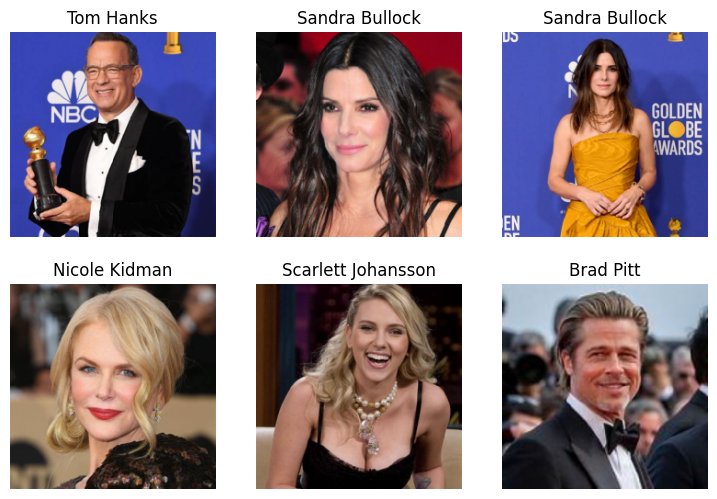

In [5]:
loaders.valid.show_batch(max_n=6, nrows=2)

In [6]:
classes = len(loaders.vocab)
classes

17

In [7]:
# Reference
# https://github.com/rwightman/pytorch-image-models/blob/499790e117b2c8c1b57780b73d16c28b84db509e/timm/models/layers/triplet.py
# https://github.com/landskape-ai/triplet-attention/blob/master/MODELS/triplet_attention.py

class BasicConv(nn.Module):
    def __init__(
        self,
        in_planes,
        out_planes,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        relu=True,
        bn=True,
        bias=False,
        act_layer=nn.ReLU,
    ):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(
            in_planes,
            out_planes,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
        )
        self.bn = (
            nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True)
            if bn
            else None
        )
        self.relu = act_layer if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x, inplace=True)
        return x


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat(
            (torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1
        )


class SpatialGate(nn.Module):
    def __init__(self, act_layer=nn.ReLU, kernel_size=7):
        super(SpatialGate, self).__init__()
        self.compress = ChannelPool()
        self.spatial = BasicConv(
            2,
            1,
            kernel_size,
            stride=1,
            padding=(kernel_size - 1) // 2,
            relu=False,
            act_layer=act_layer,
        )

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid_(x_out)
        return x * scale


class TripletAttention(nn.Module):
    def __init__(
        self,
        gate_channels,
        reduction_ratio=16,
        pool_types=["avg", "max"],
        no_spatial=False,
        act_layer=nn.ReLU,
        kernel_size=attention_kernel_size,
    ):
        super(TripletAttention, self).__init__()
        self.ChannelGateH = SpatialGate(act_layer=act_layer, kernel_size=kernel_size)
        self.ChannelGateW = SpatialGate(act_layer=act_layer, kernel_size=kernel_size)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate(kernel_size=kernel_size)

    def forward(self, x):
        x_perm1 = x.permute(0, 2, 1, 3).contiguous()
        x_out1 = self.ChannelGateH(x_perm1)
        x_out11 = x_out1.permute(0, 2, 1, 3).contiguous()
        x_perm2 = x.permute(0, 3, 2, 1).contiguous()
        x_out2 = self.ChannelGateW(x_perm2)
        x_out21 = x_out2.permute(0, 3, 2, 1).contiguous()
        if not self.no_spatial:
            x_out = self.SpatialGate(x)
            x_out = (1 / 3) * (x_out + x_out11 + x_out21)
        else:
            x_out = (1 / 2) * (x_out11 + x_out21)
        return x_out

In [8]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        #assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        #padding = 3 if kernel_size == 7 else 1
        padding = (kernel_size - 1) // 2

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=attention_kernel_size):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x

In [9]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [10]:
#GeM Pooling可以看作Average Pooling和Max Pooling的延申
#当p=1时，GeM Pooling退化成Average Pooling
#当p无穷大时，GeM pooling 等效于Max Pooling
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

class CustomModel(nn.Module):
    def __init__(self, encoder, head, attention=False):
        super().__init__()
        self.encoder = encoder
        self.head = head
        self.VPB_avgpool = AdaptiveAvgPool((1, 1))
        self.HPB_avgpool = AdaptiveAvgPool((1, 1))

        self.HPB_conv1_1 = nn.Conv2d(embedding_size, chunk_size, 1)
        self.VPB_conv1_1 = nn.Conv2d(embedding_size, chunk_size, 1)

        self.global_pooling = global_pooling
        if self.global_pooling == 'GeM':
            self.global_pooling = GeM(p=GeM_p)
        elif self.global_pooling == 'GAP':
            self.global_pooling = nn.AdaptiveAvgPool2d((1, 1))
        elif self.global_pooling == 'GMP':
            self.global_pooling = nn.AdaptiveMaxPool2d((1, 1))
        else:
            self.global_pooling = nn.Identity()

        self.attention = attention
        if self.attention == 'triplet':
            self.attention_block = TripletAttention(embedding_size)
        elif self.attention == 'se':
            self.attention_block = SEBlock(embedding_size)
        elif self.attention == 'cbam':
            self.attention_block = CBAM(embedding_size)
        else:
            self.attention_block = nn.Identity()

    def VPB(self, x):
        x = torch.chunk(x, chunk_nums, dim=3)
        x = [self.VPB_avgpool(chunk) for chunk in x]
        x = [self.VPB_conv1_1(chunk) for chunk in x]
        x = [chunk.view(chunk.size(0), -1) for chunk in x]
        x = torch.cat(x, dim=1)
        return x
    def HPB(self, x):
        x = torch.chunk(x, chunk_nums, dim=2)
        x = [self.HPB_avgpool(chunk) for chunk in x]
        x = [self.HPB_conv1_1(chunk) for chunk in x]
        x = [chunk.view(chunk.size(0), -1) for chunk in x]
        x = torch.cat(x, dim=1)
        return x
    def GPB(self, x):
        x = self.global_pooling(x)
        x = x.view(x.size(0), -1)
        return x
    def forward(self, x):
        x = self.encoder(x)
        #print(x.shape)
        x = self.attention_block(x)
        horizontal_embeddings = self.HPB(x)
        vertical_embeddings = self.VPB(x)
        global_embeddings = self.GPB(x)
        classification = self.head(x)
        return horizontal_embeddings, vertical_embeddings, global_embeddings, classification

backbone = backbone
encoder = create_body(backbone)
# head = nn.Sequential(
#     #nn.BatchNorm1d(2048),
#     nn.Linear(2048, classes)
# )
head = create_head(embedding_size, classes, [1024, 512], 0.5, bn_final=bn_final)
apply_init(head, nn.init.kaiming_normal_)

model=torch.nn.DataParallel(CustomModel(encoder, head, attention=use_attention)) if DP else CustomModel(encoder, head, attention=use_attention)
def siamese_splitter(model):
    return [params(model.module.encoder), params(model.module.head)] if DP else [params(model.encoder), params(model.head)]

In [11]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0.1, high=0.9)
#regularizer = regularizers.RegularFaceRegularizer()
loss_func = losses.TripletMarginLoss(margin=0.2, 
                                     distance=distance, 
                                     reducer=reducer,
                                     #embedding_regularizer=regularizer
                                     )
mining_func = miners.TripletMarginMiner(margin=0.2,
                                        distance=distance,
                                        type_of_triplets="semihard")
#mining_func = miners.BatchHardMiner(distance=distance)
classification_loss = torch.nn.CrossEntropyLoss()
#classification_loss = LabelSmoothingCrossEntropy()
# def mined_loss(miner, loss_func):
#     def loss(embeddings, labels):
#         mined = miner(embeddings, labels)
#         return loss_func(embeddings, labels, mined)
#     return loss

# my_loss = mined_loss(miner = mining_func, loss_func = loss_func)

class MinedLoss(nn.Module):
    def __init__(self, miner, loss_func, add_ap_dists=None):
        super().__init__()
        self.miner = miner
        self.loss_func = loss_func
        self.add_ap_dists = add_ap_dists
    def forward(self, embeddings, labels):
        mined = self.miner(embeddings, labels)
        embedding_loss = self.loss_func(embeddings, labels, mined)
        ap_dists = self.loss_func.ap_dists
        #print(f"AP Dist {self.add_ap_dists}: ", torch.mean(ap_dists))
        if self.add_ap_dists == 'mean':
            return embedding_loss + alpha * torch.mean(ap_dists)
        elif self.add_ap_dists == 'max':
            return embedding_loss + alpha * torch.max(ap_dists)
        elif self.add_ap_dists == 'min':
            return embedding_loss + alpha * torch.min(ap_dists)
        else:
            return embedding_loss

class CombinedLoss(nn.Module):
    def __init__(self, embed_loss_func, class_loss_func, with_embed, with_local):
        super().__init__()
        self.hor_emb_loss = embed_loss_func
        self.ver_emb_loss = embed_loss_func
        self.glob_emb_loss = embed_loss_func
        self.class_loss_func = class_loss_func
        self.with_embed = with_embed
        self.with_local = with_local
    def forward(self, preds, target):
        #embeddings, classifications = preds
        horizontal_embeddings, vertical_embeddings, global_embeddings, classifications = preds

        horizontal_loss = self.hor_emb_loss(horizontal_embeddings, target)
        vertical_loss = self.ver_emb_loss(vertical_embeddings, target)
        global_loss = self.glob_emb_loss(global_embeddings, target)
        
        class_loss = self.class_loss_func(classifications, target)
        if self.with_local:
            return global_loss + class_loss + horizontal_loss if with_horizontal else 0 + vertical_loss if with_vertical else 0
        elif self.with_embed:
            return global_loss + class_loss
        else:
            return class_loss
        
embedding_loss = MinedLoss(mining_func, loss_func, add_ap_dists=add_ap_dist)
combined_loss = CombinedLoss(embedding_loss, classification_loss, with_embed=with_embed,with_local=with_local)

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[-1].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def precision(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return precision_score(targ, pred, average='macro',zero_division=1)

def recall(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return recall_score(targ, pred, average='macro',zero_division=1)

def f1score(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return f1_score(targ, pred, average='macro')

def top_k_accuracy(inp, targ, k=5, axis=-1):
    "Computes the Top-k accuracy (`targ` is in the top `k` predictions of `inp`)"
    inp = inp[-1].topk(k=k, dim=axis)[1]
    targ = targ.unsqueeze(dim=axis).expand_as(inp)
    return (inp == targ).sum(dim=-1).float().mean()

def top_2_accuracy(inp, targ):
    return top_k_accuracy(inp, targ, k=2)

learn=Learner(loaders, 
              model,
              loss_func=combined_loss,
              splitter=siamese_splitter,
              cbs=[WandbCallback(),
                   ShowGraphCallback(),
                   SaveModelCallback(monitor='accuracy')],
              metrics=[accuracy, precision, recall, f1score]).to_fp16()

epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,3.121455,2.774098,0.116667,0.179133,0.167666,0.094886,00:13
1,2.929423,2.341781,0.222222,0.281243,0.275288,0.183953,00:11
2,2.643430,1.987838,0.302778,0.374437,0.346514,0.278942,00:11
3,2.389232,1.765557,0.411111,0.465164,0.437582,0.374087,00:11
4,2.186652,1.663600,0.452778,0.481030,0.469866,0.410311,00:11
5,2.012073,1.591093,0.494444,0.511646,0.519244,0.456525,00:11
6,1.875175,1.527723,0.480556,0.536476,0.498164,0.443337,00:11
7,1.738798,1.461559,0.516667,0.528134,0.537871,0.476921,00:11
8,1.623534,1.376410,0.558333,0.568126,0.577694,0.522186,00:11
9,1.514737,1.323323,0.572222,0.588551,0.588727,0.538648,00:11


Better model found at epoch 0 with accuracy value: 0.11666666716337204.


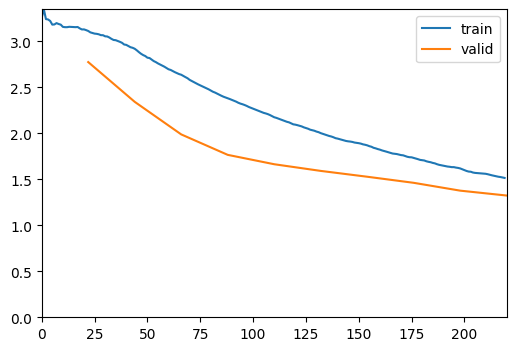

Better model found at epoch 1 with accuracy value: 0.2222222238779068.
Better model found at epoch 2 with accuracy value: 0.3027777671813965.
Better model found at epoch 3 with accuracy value: 0.41111111640930176.
Better model found at epoch 4 with accuracy value: 0.45277777314186096.
Better model found at epoch 5 with accuracy value: 0.49444442987442017.
Better model found at epoch 7 with accuracy value: 0.5166666507720947.
Better model found at epoch 8 with accuracy value: 0.5583333373069763.
Better model found at epoch 9 with accuracy value: 0.5722222328186035.
WandbCallback was not able to get prediction samples -> Match length mismatch


epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,1.240594,1.308585,0.580556,0.610331,0.592266,0.552330,00:14
1,1.198111,1.295922,0.577778,0.598135,0.593582,0.539249,00:14
2,1.163167,1.246698,0.608333,0.617004,0.616136,0.570935,00:14
3,1.132923,1.225524,0.627778,0.654642,0.636839,0.591761,00:14
4,1.084841,1.175294,0.633333,0.646932,0.646222,0.590490,00:14
5,1.047058,1.143545,0.647222,0.671123,0.651378,0.604836,00:14
6,0.993354,1.055753,0.669444,0.706989,0.696801,0.633147,00:14
7,0.949309,1.015929,0.702778,0.729136,0.717339,0.668956,00:14
8,0.898043,0.988195,0.700000,0.728500,0.725358,0.673025,00:14
9,0.851086,0.994947,0.694444,0.727133,0.711590,0.659438,00:14


Better model found at epoch 0 with accuracy value: 0.5805555582046509.


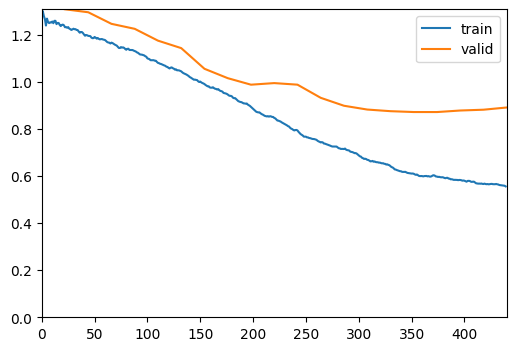

Better model found at epoch 2 with accuracy value: 0.6083333492279053.
Better model found at epoch 3 with accuracy value: 0.6277777552604675.
Better model found at epoch 4 with accuracy value: 0.6333333253860474.
Better model found at epoch 5 with accuracy value: 0.6472222208976746.
Better model found at epoch 6 with accuracy value: 0.6694444417953491.
Better model found at epoch 7 with accuracy value: 0.7027778029441833.
Better model found at epoch 10 with accuracy value: 0.7083333134651184.
Better model found at epoch 11 with accuracy value: 0.7444444298744202.
Better model found at epoch 13 with accuracy value: 0.7472222447395325.
Better model found at epoch 14 with accuracy value: 0.7583333253860474.


In [13]:
learn.fine_tune(unfreeze_epochs,freeze_epochs=freeze_epochs)

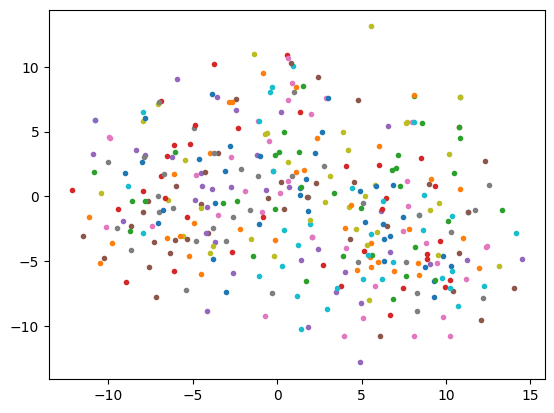

In [14]:
hooks = Hooks(model.module.encoder if DP else model.encoder, lambda m,i,o: o)
ftrs_list = []
with torch.no_grad():
    for i in learn.dls.valid:
        learn.model(i[0])
        hooks_output = nn.Flatten()(hooks.stored[-1])
        hooks_output = hooks_output.to('cuda')  # move hooks_output to the same device as ftrs
        ftrs_list.append(hooks_output)

ftrs = torch.cat(ftrs_list)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')
# 保存图像
plt.savefig("output.png")

In [15]:
wandb.log({"output": wandb.Image("output.png")})
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:              accuracy ▁▂▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████████
wandb:                 epoch ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                 eps_0 ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                 eps_1 ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:               f1score ▁▂▃▄▄▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇█████████
wandb:                  lr_0 ▁▁▂▂▃▄▄▅▆▇▇██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                  lr_1 ▁▁▂▂▃▄▄▅▆▇▇██▂▂▂▃▃▄▄▄▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
wandb:                 mom_0 ██▇▇▆▆▅▄▃▃▂▁▁██▇▆▄▃▂▁▁▁▁▁▂▂▃▃▄▄▅▆▆▇▇▇███
wandb:                 mom_1 ██▇▇▆▆▅▄▃▃▂▁▁██▇▆▄▃▂▁▁▁▁▁▂▂▃▃▄▄▅▆▆▇▇▇███
wandb:             precision ▁▂▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇█████████████
wandb:              raw_loss █▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▂▁▁
wandb:                recall ▁▂▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████████
wandb:             sqr_mom_0 ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:         

# 